# This notebook runs ...

In [1]:
import os
import pathlib
import yaml
import subprocess
import re
from collections import defaultdict

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from matplotlib_venn import venn2, venn3
import seaborn as sns

import tensorflow as tf

2025-03-18 15:24:10.546333: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 15:24:10.566586: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-18 15:24:10.566595: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-18 15:24:10.566600: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 15:24:10.570387: I tensorflow/core/platform/cpu_feature_g

## Metadata Column Definition

In [2]:
CELL_TYPE_COL = 'encode_celltype'
SAMPLE_ID_COL = 'sample_id'
STIM_COL = 'stim'

GENE_ID_COL = 'gene_ids'

DATASPLIT_COL = 'isTraining'

## Define paths to Required Input Files

### Load config
The config file specifies the path to data and software repo (due to currently in active development)

In [3]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)

CONFIG_FILE = REPO_ROOT / 'config.yml'
assert CONFIG_FILE.exists(), f"Config file not found at {CONFIG_FILE}"

with open(CONFIG_FILE, 'r') as file:
    config_dict = yaml.safe_load(file)

### Check for Pre-Processing Output presence

In [4]:
PREPROCESSING_OUTPUT_PATH = REPO_ROOT / 'processed_data'
assert PREPROCESSING_OUTPUT_PATH.exists(), f"Preprocessing output path {PREPROCESSING_OUTPUT_PATH} does not exist"

SC_AUGMENTED_DATA_PATH = PREPROCESSING_OUTPUT_PATH / 'sc_augmented'
assert SC_AUGMENTED_DATA_PATH.exists(), f"Single cell augmented data path {SC_AUGMENTED_DATA_PATH} does not exist"
pseudobulk_files = list(SC_AUGMENTED_DATA_PATH.glob('*_splits.pkl'))
assert len(pseudobulk_files) > 0, f"No pseudobulk files found in {SC_AUGMENTED_DATA_PATH}"

BULK_FORMAT_DATA_PATH = PREPROCESSING_OUTPUT_PATH / 'bulk_formatted'
assert BULK_FORMAT_DATA_PATH.exists(), f"Bulk format data path {BULK_FORMAT_DATA_PATH} does not exist"
formatted_bulk_files = list(BULK_FORMAT_DATA_PATH.glob('*.h5ad'))
assert len(formatted_bulk_files) > 0, f"No formatted bulk files found in {BULK_FORMAT_DATA_PATH}"

### Hard-coded path to Cibersortx signature gene file (TODO make this more elegant?)

In [5]:
CIBERSORTX_SIG_GENE_FILE = pathlib.Path(config_dict['data_path']['sc_data_path']) /\
    'GSE154600_cibersortx_output' /\
    'CIBERSORTx_Job4_GSM4675273_cibersortx_sc_reference_input_inferred_phenoclasses.CIBERSORTx_Job4_GSM4675273_cibersortx_sc_reference_input_inferred_refsample.bm.K999.txt'
assert CIBERSORTX_SIG_GENE_FILE.exists(), f"CIBERSORTx signature gene file not found at {CIBERSORTX_SIG_GENE_PATH}"

## Load Processed Data and Feature select using cibersortx

### Cibersortx signature genes

In [6]:
cibersortx_sig_df = pd.read_csv(CIBERSORTX_SIG_GENE_FILE, sep='\t', header=0)
cibersortx_sig_genes = cibersortx_sig_df['NAME'].values.tolist()
print(f"{len(cibersortx_sig_genes)} signature genes from CIBERSORTx")

2892 signature genes from CIBERSORTx


### Processed Bulk

In [7]:
## TODO support for multiple formatted bulk files
processed_bulk = sc.read(formatted_bulk_files[0]) # Assumes only single file for processed bulk

In [8]:
bulk_sample_ids = processed_bulk.obs[SAMPLE_ID_COL].unique()
n_bulk_samples = len(bulk_sample_ids)
print(f"Number of bulk samples: {n_bulk_samples}")

bulk_stims = processed_bulk.obs[STIM_COL].unique()
n_bulk_stims = len(bulk_stims)
print(f"Number of bulk stims: {n_bulk_stims}")

bulk_genes = processed_bulk.var[GENE_ID_COL].values.tolist()
print(f"Number of bulk genes: {len(bulk_genes)}")

Number of bulk samples: 588
Number of bulk stims: 2
Number of bulk genes: 18509


### Pseudobulks

In [9]:
sc_gene_file = SC_AUGMENTED_DATA_PATH.glob('*_genes.pkl')
sc_gene_file = list(sc_gene_file)[0]
sc_genes = pd.read_pickle(sc_gene_file)
print(f"Number of single cell genes: {len(sc_genes)}")


Number of single cell genes: 24520


### Visualize the overlap of genes

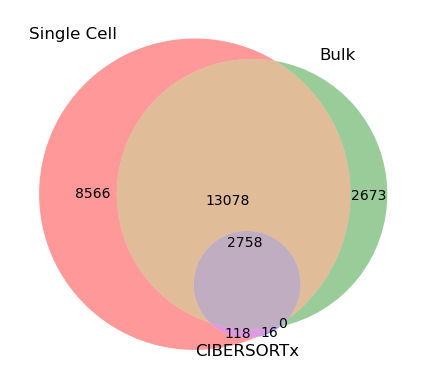

In [10]:
venn3(
    [
        set(sc_genes),
        set(bulk_genes),
        set(cibersortx_sig_genes)
    ],
    set_labels=['Single Cell', 'Bulk', 'CIBERSORTx']
)

### Subset bulk

In [11]:
sc_bulk_intersection_genes = set(sc_genes).intersection(set(bulk_genes))
sc_bulk_intersection_genes = list(sc_bulk_intersection_genes)
print(f"Number of genes in intersection of single cell and bulk: {len(sc_bulk_intersection_genes)}")

## Subset the bulk data to only include the intersection genes
processed_bulk = processed_bulk[
    :, 
    processed_bulk.var[GENE_ID_COL].isin(sc_bulk_intersection_genes)]

X_bulk_train = pd.DataFrame(
    processed_bulk.X,
    index=processed_bulk.obs[SAMPLE_ID_COL],
    columns=processed_bulk.var[GENE_ID_COL]
)

# No Y for real bulk

# Add metadata columns 
## TODO: perhaps move this to preprocessing?
meta_bulk_train = processed_bulk.obs.loc[:,[SAMPLE_ID_COL, STIM_COL]]
meta_bulk_train['isTraining'] = 'Train'
meta_bulk_train['cell_prop_type'] = 'bulk'
meta_bulk_train['samp_type'] = 'bulk'

Number of genes in intersection of single cell and bulk: 15836


### Load Pseudobulk

In [12]:
pattern = re.compile(r'^(.*)_((?:Train)|(?:Test))_((?:meta)|(?:prop)|(?:pseudo))_splits\.pkl$')

# Temporary dictionary to group by sample_id
temp_dict = defaultdict(lambda: defaultdict(dict))

for path in pseudobulk_files:
    file = path.name
    match = pattern.match(file)
    if match:
        sample_id, datasplit, datatype = match.groups()
        temp_dict[datasplit][sample_id][datatype] = path

# Organizing the sorted results
grouped_files = {
    "Train": {"meta": [], "prop": [], "pseudo": []},
    "Test": {"meta": [], "prop": [], "pseudo": []}
}

# Sort within each datasplit by sample_id and organize the lists
for datasplit in ["Train", "Test"]:
    sorted_samples = sorted(temp_dict[datasplit].keys())  # Sort by sample_id
    for sample_id in sorted_samples:
        for datatype in ["meta", "prop", "pseudo"]:
            if datatype in temp_dict[datasplit][sample_id]:
                grouped_files[datasplit][datatype].append(temp_dict[datasplit][sample_id][datatype])

meta_sc_train = pd.concat(
    [pd.read_pickle(file) for file in grouped_files['Train']['meta']]
)
meta_sc_train['stim'] = 'white' # ugly fix
Y_sc_train = pd.concat(
    [pd.read_pickle(file) for file in grouped_files['Train']['prop']]
)
X_sc_train = pd.concat(
    [pd.read_pickle(file).loc[:, sc_bulk_intersection_genes] for file in grouped_files['Train']['pseudo']]
)

### Concatenate X, Y and Encode Metadata

In [13]:
# Generate place holder for bulk proportion (not used)
Y_bulk_dummy = pd.DataFrame(
    np.zeros((X_bulk_train.shape[0], Y_sc_train.shape[1])),
    columns=Y_sc_train.columns
)

X_concat = pd.concat([X_bulk_train, X_sc_train])
Y_concat = pd.concat([Y_bulk_dummy, Y_sc_train])
meta_concat = pd.concat([meta_bulk_train, meta_sc_train])

# save gene and cell type names
X_gene_names = X_concat.columns.to_list()
Y_cell_type_names = Y_concat.columns.to_list()

# to numpy matrix
X = X_concat.to_numpy()
X = (X.T / X.sum(axis=1)).T * 1e4 # libsize normalization

Y = Y_concat.to_numpy()

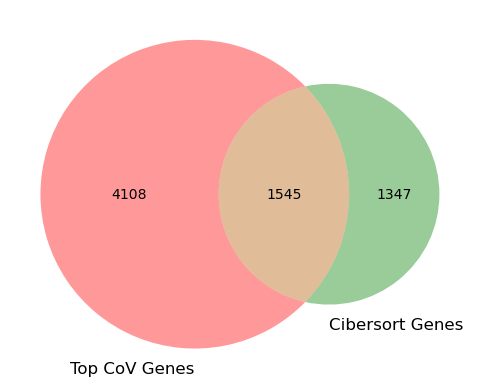

In [14]:
## get the top variable genes
X_colmean = X.mean(axis=0) # mean across samples
X_colvar = X.var(axis=0) # variance across samples
# coefficient of variation which is the var to mean ratio
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001)) 

# need to get the genes such that
# the union of the highly variable and the
# CIBERSORTx genes are 7000 total
num_genes_found = False

gene_df = pd.DataFrame(X_gene_names, columns=['gene'])

# start with top 7000 genes by CoV
initial_count = 7000
while not num_genes_found:
    # retrieve the top initial_count genes by CoV
    idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:]
    # get gene names from idx_top
    top_gene_df = gene_df.iloc[idx_top]

    # produce the union of the top genes and the cibersort genes
    CoV_only = np.union1d(top_gene_df, cibersortx_sig_genes)

    # check if the union is 7000
    if len(CoV_only) == 7000:
        num_genes_found = True
    else:
        # if not decrement the top CoV gene to retrieve by 1
        # in the next iteration, there will be two possibilities
        # 1. the union will have one less gene due to the removed gene being only in the CoV genes
        # 2. the union will have the same number of genes as this iteration due to the removed 
        #    gene being also present in CIBERSORTx genes
        # keep running this loop until the union has 7000 genes
        initial_count = initial_count -1

idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:] # num_genes to get 7000
gene_df = gene_df.iloc[idx_top]
venn2([set(gene_df.values.flatten()), 
       set(cibersortx_sig_genes)], 
       set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

feature_select_genes = np.union1d(gene_df, cibersortx_sig_genes)
X = X[:, np.isin(X_gene_names, feature_select_genes)]

In [15]:
FIELDS_TO_ENCODE = [SAMPLE_ID_COL, STIM_COL, 'samp_type']

encoded = {}

for field in FIELDS_TO_ENCODE:
    encoder = OneHotEncoder(dtype=int)
    encoded[field] = pd.DataFrame(
        encoder.fit_transform(meta_concat.loc[:,[field]]).toarray(),
        columns=encoder.get_feature_names_out([field])
    )

### Final normalization

In [16]:
## normalize within sample
clip_upper = np.quantile(X, 0.9)
X_full = np.clip(X, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)

In [17]:
idx_train = np.where(meta_concat.isTraining=="Train")[0] 
idx_bulk = np.where(meta_concat.samp_type == "bulk")[0]

# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 

In [18]:
idx_train = np.where(meta_concat.isTraining=="Train")[0] 
idx_bulk = np.where(meta_concat.samp_type == "bulk")[0]
idx_sc = np.where(meta_concat.samp_type != "bulk")[0]

# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = encoded['sample_id'].values[idx_bulk_train,]
drug_unkp = encoded['stim'].values[idx_bulk_train,]
bulk_unkp = encoded['samp_type'].values[idx_bulk_train,]
y_unkp = Y[idx_bulk_train,]

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = encoded['sample_id'].values[idx_sc_train,]
drug_kp = encoded['stim'].values[idx_sc_train,]
bulk_kp = encoded['samp_type'].values[idx_sc_train,]
y_kp = Y[idx_sc_train,]

# Plot all data

In the plot below, we plot the pseudobulk and real bulk data. Each plot will have a different coloration in order to highlight the different confounders present in the data.
In the first plot, it is colored by sample ID, but since there are >500 real bulk samples, we hide the legend.
The final plot is colored by the cell-type that has the highest proportion in the pseudobulk. 
For the bulk data, this is a random cell-type.

In [19]:
# from sklearn.manifold import TSNE
# def get_tsne_for_plotting(encodings):
#     tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=500)
#     tsne_results = tsne.fit_transform(encodings)

#     plot_df = pd.DataFrame(tsne_results[:,0:2])
#     print(tsne_results.shape)
#     print(plot_df.shape)
#     plot_df.columns = ['tsne_0', 'tsne_1']
#     return plot_df

# def plot_tsne(plot_df, color_vec, ax, title="", alpha=0.1, legend_title="Y"):

#     plot_df[legend_title] = color_vec

#     g = sns.scatterplot(
#         x="tsne_0", y="tsne_1",
#         data=plot_df,
#         hue=legend_title,
#         palette=sns.color_palette("hls", len(np.unique(color_vec))),
#         legend="full",
#         alpha=alpha, ax= ax
#     )

#     ax.set_title(title)
#     sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#     return g

# ## plot samples
# plot_df = get_tsne_for_plotting(X_full)

# fig, axs = plt.subplots(2, 3, figsize=(30,15))

# Y_temp = np.copy(Y)
# Y_temp = np.argmax(Y_temp, axis=1) 

# plot_tsne(plot_df, meta_concat.sample_id.to_numpy(), axs[0,0], title=f"")
# plot_tsne(plot_df, meta_concat.stim.to_numpy(), axs[0,1], title=f"")
# plot_tsne(plot_df, meta_concat.isTraining.to_numpy(), axs[0,2], title=f"")
# plot_tsne(plot_df, meta_concat.cell_prop_type.to_numpy(), axs[1,0], title=f"")
# plot_tsne(plot_df, meta_concat.samp_type.to_numpy(), axs[1,1], title=f"")
# plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


# fig.suptitle("All Data, normalized using training data", fontsize=14)

# axs[0,0].legend([],[], frameon=False)

# fig.show()

## Prototyping Training

In [20]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU
import tensorflow as tf

In [21]:
n_x = X_full.shape[1]
n_y = Y.shape[1]
n_labels = encoded['sample_id'].shape[1]
n_stims = encoded['stim'].shape[1]
n_samp_types = encoded['samp_type'].shape[1]

In [ ]:
from prototype_buddi import build_buddi
from prototype_buddi_dataset import *

2025-03-18 15:24:24.695464: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-03-18 15:24:24.695485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: pop-os
2025-03-18 15:24:24.695489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: pop-os
2025-03-18 15:24:24.695574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 570.124.4
2025-03-18 15:24:24.695587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 570.124.4
2025-03-18 15:24:24.695590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 570.124.4


In [23]:
supervised_buddi, unsupervised_buddi = build_buddi(
    n_x=n_x,
    n_y=n_y,
    n_labels=n_labels,
    n_stims=n_stims,
    n_samp_types=n_samp_types,
)

In [25]:
batch_size = 16
dataset_supervised = tf.data.Dataset.from_generator(
    lambda: dataset_generator(X_kp, y_kp, label_kp, drug_kp, bulk_kp),
    output_signature=get_output_signature(X_kp, y_kp, label_kp, drug_kp, bulk_kp)
).batch(batch_size)

dataset_unsupervised = tf.data.Dataset.from_generator(
    lambda: dataset_generator_unsupervised(X_unkp, label_unkp, drug_unkp, bulk_unkp),
    output_signature=get_output_signature_unsupervised(X_unkp, label_unkp, drug_unkp, bulk_unkp)
).batch(batch_size)

In [27]:
print("Debug Dataset")
for batch in dataset_supervised.take(1):
    x, y = batch
    print("Input batch shapes:", [xi.shape for xi in x])
    print("Output batch shapes:", [yi.shape for yi in y])
    break

print("Debug Model Forward Pass")
for batch in dataset_supervised.take(1):
    x, _ = batch
    y_pred = supervised_buddi(x)
    print("Model output shapes:", [yp.shape for yp in y_pred])
    break


Debug Dataset
Input batch shapes: [TensorShape([16, 6866]), TensorShape([16, 11])]
Output batch shapes: [TensorShape([16, 6866]), TensorShape([16, 1]), TensorShape([16, 1]), TensorShape([16, 1]), TensorShape([16, 1]), TensorShape([16, 593]), TensorShape([16, 2]), TensorShape([16, 2]), TensorShape([16, 11])]
Debug Model Forward Pass
Model output shapes: [TensorShape([16, 6866]), TensorShape([16, 128]), TensorShape([16, 128]), TensorShape([16, 128]), TensorShape([16, 128]), TensorShape([16, 593]), TensorShape([16, 2]), TensorShape([16, 2]), TensorShape([16, 11])]


In [28]:
print("Debug Dataset")
for batch in dataset_unsupervised.take(1):
    x, y = batch
    print("Input batch shapes:", [xi.shape for xi in x])
    print("Output batch shapes:", [yi.shape for yi in y])
    break

print("Debug Model Forward Pass")
for batch in dataset_unsupervised.take(1):
    x, _ = batch
    y_pred = unsupervised_buddi(x)
    print("Model output shapes:", [yp.shape for yp in y_pred])
    break


Debug Dataset
Input batch shapes: [TensorShape([6866]), TensorShape([6866]), TensorShape([6866]), TensorShape([6866]), TensorShape([6866]), TensorShape([6866]), TensorShape([6866]), TensorShape([6866]), TensorShape([6866]), TensorShape([6866]), TensorShape([6866]), TensorShape([6866]), TensorShape([6866]), TensorShape([6866]), TensorShape([6866]), TensorShape([6866])]
Output batch shapes: [TensorShape([16, 6866]), TensorShape([16, 1]), TensorShape([16, 1]), TensorShape([16, 1]), TensorShape([16, 1]), TensorShape([16, 593]), TensorShape([16, 2]), TensorShape([16, 2]), TensorShape([16, 1])]
Debug Model Forward Pass
Model output shapes: [TensorShape([16, 6866]), TensorShape([16, 128]), TensorShape([16, 128]), TensorShape([16, 128]), TensorShape([16, 128]), TensorShape([16, 593]), TensorShape([16, 2]), TensorShape([16, 2]), TensorShape([16, 11])]


In [29]:
count = 0
for batch in dataset_supervised:
    x, y = batch
    try:
        loss = supervised_buddi.train_on_batch(x, y)
    except Exception as e:
        print(f"Error on batch {count}: {e}")
        break
    count += 1

In [30]:
count = 0
for batch in dataset_unsupervised:
    x, y = batch
    try:
        loss = unsupervised_buddi.train_on_batch(x, y)
    except Exception as e:
        print(f"Error on batch {count}: {e}")
        break
    count += 1

In [ ]:
max_epochs = 50
for epoch in max_epochs:
    _log1 = supervised_buddi.fit(dataset_supervised, epochs=1)
    _log2 = unsupervised_buddi.fit(dataset_unsupervised, epochs=1)
    

In [31]:
log = supervised_buddi.fit(dataset_supervised, epochs=1)
log.history

657/657 [==============================] - 25s 38ms/step - loss: 3.1757 - supervised_X_decoder_loss: 0.3213 - encoder_label_loss: 0.0019 - encoder_stim_loss: 0.0052 - encoder_samp_type_loss: 0.0023 - encoder_slack_loss: 1.7668e-04 - classifier_label_loss: 0.0466 - classifier_stim_loss: 0.0800 - classifier_samp_type_loss: 0.0704 - prop_estimator_loss: 2.6478


{'loss': [3.1757194995880127],
 'supervised_X_decoder_loss': [0.32134729623794556],
 'encoder_label_loss': [0.0019284529844298959],
 'encoder_stim_loss': [0.005162372253835201],
 'encoder_samp_type_loss': [0.002279707696288824],
 'encoder_slack_loss': [0.0001766847854014486],
 'classifier_label_loss': [0.04660245031118393],
 'classifier_stim_loss': [0.08001802116632462],
 'classifier_samp_type_loss': [0.0703914538025856],
 'prop_estimator_loss': [2.647812604904175]}

In [32]:
log_unsup = unsupervised_buddi.fit(dataset_unsupervised, epochs=1)
log_unsup.history

37/37 [==============================] - 2s 42ms/step - loss: 25.1285 - unsupervised_X_decoder_loss: 1.7807 - encoder_label_loss: 0.0034 - encoder_stim_loss: 0.0000e+00 - encoder_samp_type_loss: 0.0000e+00 - encoder_slack_loss: 0.0011 - classifier_label_loss: 0.0537 - classifier_stim_loss: 7.4086 - classifier_samp_type_loss: 15.8810 - prop_estimator_loss: 0.0000e+00


{'loss': [25.128488540649414],
 'unsupervised_X_decoder_loss': [1.7807127237319946],
 'encoder_label_loss': [0.003404398448765278],
 'encoder_stim_loss': [0.0],
 'encoder_samp_type_loss': [0.0],
 'encoder_slack_loss': [0.0011082435958087444],
 'classifier_label_loss': [0.05368473380804062],
 'classifier_stim_loss': [7.40858268737793],
 'classifier_samp_type_loss': [15.880995750427246],
 'prop_estimator_loss': [0.0]}